<a href="https://colab.research.google.com/github/bezhvin/PyData2020-Eindhoven/blob/main/PyData_missingdata.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%tensorflow_version 2.x

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import tensorflow as tf
from tensorflow import keras
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from fancyimpute import KNN
from fancyimpute import IterativeImputer as MICE

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


In [8]:
def plot(samples, strategy=None):
    fig = plt.figure(figsize = (10,10))
    gs = gridspec.GridSpec(5,5)
    gs.update(wspace=0.05, hspace=0.05)
    
    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(28,28))
    if strategy is not None:
      fig.suptitle(f'{strategy} imputation')    
    return fig

**Reading and preparing data**


In [9]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data(path='mnist.npz')
Dim = x_train.shape[1] * x_train.shape[2]
x_train=x_train.reshape((x_train.shape[0],Dim))
x_train = x_train / x_train.max()
x_test=x_test.reshape((x_test.shape[0],Dim))
x_test = x_test / x_test.max()

**Adding missingness randomly**

In [10]:
  def induce_missingness(data, p_missing=0.2):
    new_data= np.copy(data)
    A = np.random.uniform(0., 1., size = [data.shape[0], data.shape[1]])
    B = A < p_missing
    new_data[B] = np.nan
    return new_data

x_train_miss = induce_missingness(x_train)
x_test_miss = induce_missingness(x_test)


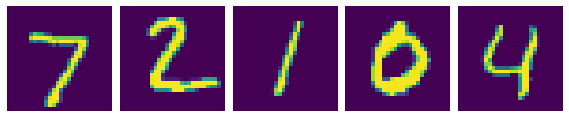

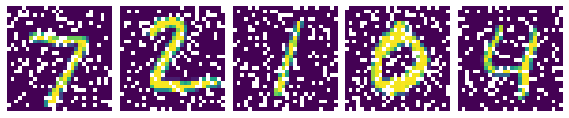

In [12]:
## how image would look like after imposing 20% missingness
fig = plot(x_test[0:5])
fig = plot(x_test_miss[0:5])

## **Single imputation**

Mean and Median

---STRATEGY : mean ---
MSE for train data : 0.013447442857751887
MSE for test data : 0.013544010746408475
---STRATEGY : median ---
MSE for train data : 0.017376949169210166
MSE for test data : 0.01764559307987901


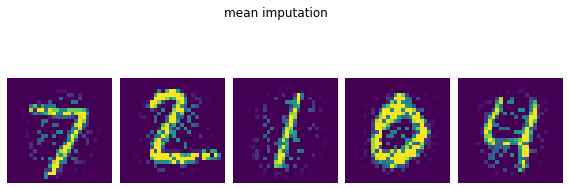

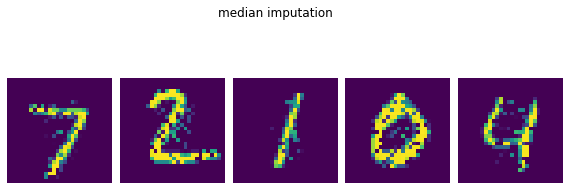

In [13]:
for strategy in ('mean', 'median'):
  imputer = SimpleImputer(missing_values=np.nan, strategy=strategy).fit(x_train_miss)
  x_train_imputed = imputer.transform(x_train_miss)
  x_test_imputed = imputer.transform(x_test_miss)
  print(f"---STRATEGY : {strategy} ---")
  print(f"MSE for train data : {mean_squared_error(x_train_imputed, x_train)}")
  print(f"MSE for test data : {mean_squared_error(x_test_imputed, x_test)}")
  fig = plot(x_test_imputed[0:5], strategy) ## plotting 5 images after imputation 

*KNN imputation (only first 100 images to get fast computation)*


---STRATEGY : KNN --- (ONLY for 100 images)
MSE for train data : 0.00813462552864283
MSE for test data : 0.009391225235192115


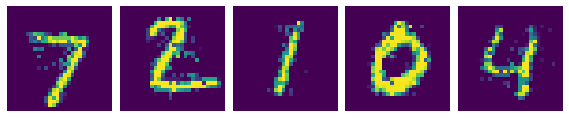

In [ ]:
imputer = KNNImputer(n_neighbors=5, weights='uniform').fit(x_train_miss[0:100]) ## playing with the hyperparameters result in differnt outputs
x_train_imputed = imputer.transform(x_train_miss[0:100])
x_test_imputed = imputer.transform(x_test_miss[0:100])
print(f"---STRATEGY : KNN --- (ONLY for 100 images)")
print(f"MSE for train data : {mean_squared_error(x_train_imputed[0:100], x_train[0:100])}")
print(f"MSE for test data : {mean_squared_error(x_test_imputed[0:100], x_test[0:100])}")
fig = plot(x_test_imputed[0:5], 'KNN') ## plotting 5 images after imputation 

## **Multiple imputation**


MICE

---STRATEGY : MICE --- (ONLY for 100 images) - dataset0
MSE for train data : 0.006002659942671736
MSE for test data : 0.0060470973658871075
---STRATEGY : MICE --- (ONLY for 100 images) - dataset1
MSE for train data : 0.005999110585084201
MSE for test data : 0.006048888083888194


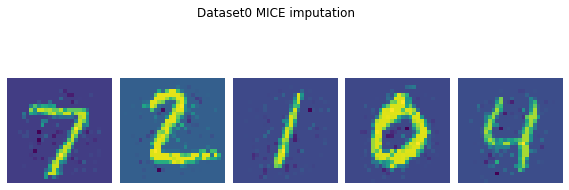

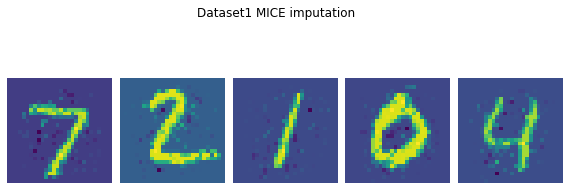

In [21]:
import warnings
warnings.filterwarnings('ignore') ## to avoide seeing deprecation warnings
### MICE is also very slow with high dimensional data
### so here we only looked at 100 images for the sake of speed
M = 2 ## M is the number of imputed datasets
for m in range(0, M): 
  imputer = MICE(random_state=m, imputation_order='random').fit(x_train_miss[0:100])
  x_train_imputed = imputer.transform(x_train_miss[0:100])
  x_test_imputed = imputer.transform(x_test_miss[0:100])
  print(f"---STRATEGY : MICE --- (ONLY for 100 images) - dataset{m}")
  print(f"MSE for train data : {mean_squared_error(x_train_imputed[0:100], x_train[0:100])}")
  print(f"MSE for test data : {mean_squared_error(x_test_imputed[0:100], x_test[0:100])}")
  fig = plot(x_test_imputed[0:5], f'Dataset{m} MICE') ## plotting 5 images after imputation

*Denoising autoencoder*



In [16]:
def fill_nan_with_noise(data): ## missing entries are filled in with random noise
  X = np.copy(data)
  Z = np.random.uniform(0,1,[data.shape[0], data.shape[1]])
  mask = np.isnan(data) 
  X[mask] = Z[mask]
  return X

In [17]:
x_train_imputed_with_noise = fill_nan_with_noise(x_train_miss)
x_test_imputed_with_noise = fill_nan_with_noise(x_test_miss)

In [19]:
from keras.layers import Dense, Input, LeakyReLU
from keras import activations 
from keras.optimizers import Adam
from keras.models import Model, Sequential

In [20]:
## An overcomlete autoencoder is structured here; noting that hyperparameters can be changed to get different results.
N, D = np.shape(x_train)
latent_dim = 2 * D ## it is an overcomplete autoencoder
inputs = Input(shape=(D,))
encoder = Sequential(
    [
     Dense(int(D * 1.5), activation=tf.nn.leaky_relu),
     Dense(latent_dim)
    ]
)
decoder = Sequential(
    [
     Dense(int(D * 1.5), activation=tf.nn.leaky_relu),
     Dense(D, activation=tf.nn.sigmoid)
    ]
)

denoising_autoencoder = Model(inputs, decoder(encoder(inputs)))
denoising_autoencoder.compile(loss='binary_crossentropy', optimizer=Adam(0.001))
denoising_autoencoder.fit(x_train_imputed_with_noise, x_train, epochs=10,
                          shuffle=True, batch_size=32)

Epoch 1/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.1042
Epoch 2/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.0898
Epoch 3/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.0868
Epoch 4/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.0849
Epoch 5/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.0836
Epoch 6/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.0825
Epoch 7/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.0817
Epoch 8/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.0810
Epoch 9/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.0804
Epoch 10/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.0800


---STRATEGY : denoising autoencoder
MSE for train data : 0.005596091701406396
MSE for test data : 0.007672137608201405 (dataset0)
MSE for test data : 0.007673921068934154 (dataset1)


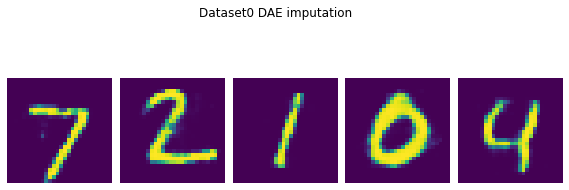

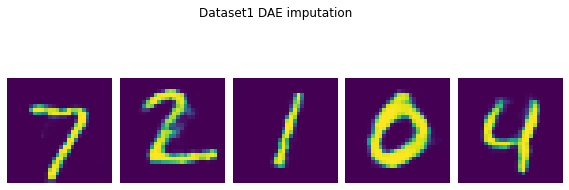

In [22]:
x_train_imputed = denoising_autoencoder.predict(x_train_imputed_with_noise)
print(f"---STRATEGY : denoising autoencoder")
print(f"MSE for train data : {mean_squared_error(x_train_imputed, x_train)}")

M = 2 ## M is number of imputed datasets
for m in range(0, M): 
  x_test_imputed = denoising_autoencoder.predict(fill_nan_with_noise(x_test_miss))
  print(f"MSE for test data : {mean_squared_error(x_test_imputed, x_test)} (dataset{m})")
  fig = plot(x_test_imputed[0:5], f'Dataset{m} DAE') ## plotting 5 images after imputation